Dataset shape: (19735, 29)
Train samples: (15740, 24, 27)
Test samples: (3899, 24, 27)
Using device: cpu
Epoch 1/30, Loss: 19303.8495
Epoch 2/30, Loss: 18165.2093
Epoch 3/30, Loss: 17761.6639
Epoch 4/30, Loss: 17509.1890
Epoch 5/30, Loss: 17323.7089
Epoch 6/30, Loss: 17172.6072
Epoch 7/30, Loss: 17047.4674
Epoch 8/30, Loss: 16938.4361
Epoch 9/30, Loss: 16841.7013
Epoch 10/30, Loss: 16749.5966
Epoch 11/30, Loss: 16665.9889
Epoch 12/30, Loss: 16587.9995
Epoch 13/30, Loss: 16515.9638
Epoch 14/30, Loss: 16445.9689
Epoch 15/30, Loss: 16378.9156
Epoch 16/30, Loss: 16316.3660
Epoch 17/30, Loss: 16252.8952
Epoch 18/30, Loss: 16194.7913
Epoch 19/30, Loss: 16135.4463
Epoch 20/30, Loss: 16080.2180
Epoch 21/30, Loss: 16024.8262
Epoch 22/30, Loss: 15973.2589
Epoch 23/30, Loss: 15920.6065
Epoch 24/30, Loss: 15869.1248
Epoch 25/30, Loss: 15822.3626
Epoch 26/30, Loss: 15771.8619
Epoch 27/30, Loss: 15724.6064
Epoch 28/30, Loss: 15677.4911
Epoch 29/30, Loss: 15629.4148
Epoch 30/30, Loss: 15587.1683
Test

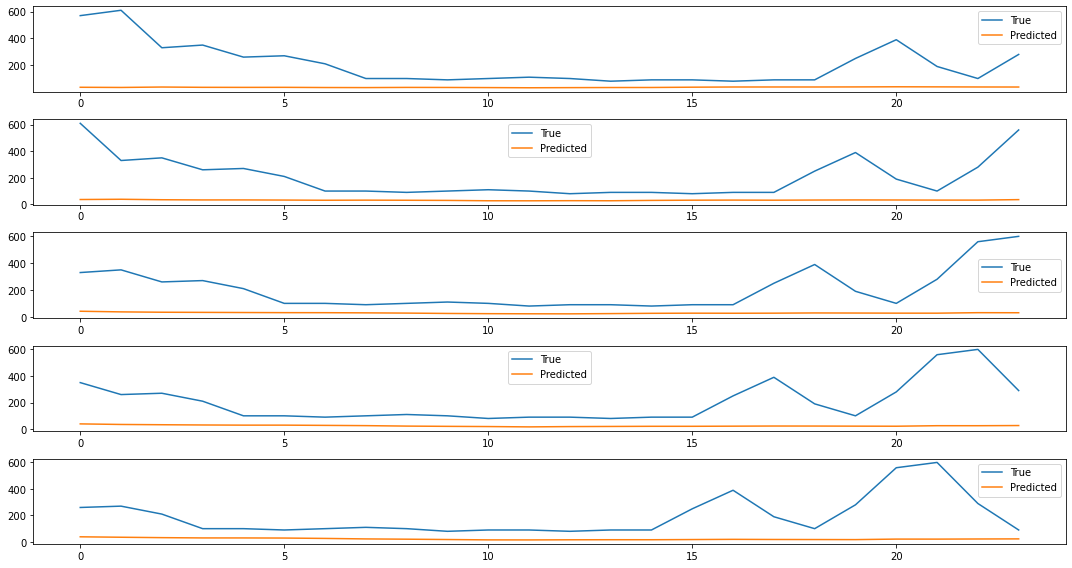

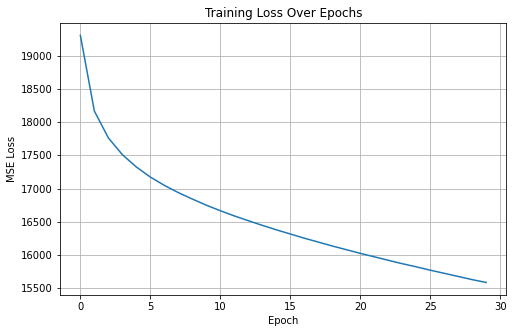

In [1]:
# Linear LTSF on Appliances Energy Prediction Dataset
# ====================================================

# Install torch if you haven't
# !pip install torch pandas scikit-learn matplotlib

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

# 1. Load Dataset
# ---------------
# Dataset source: https://archive.ics.uci.edu/dataset/374/appliances+energy+prediction

# Download the dataset manually or use pandas
# Here assuming "energydata_complete.csv" is present in working dir

DATA_PATH = 'energydata_complete.csv'

df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)
df.head()

# 2. Preprocessing
# ----------------
# Target: "Appliances" (energy use)
# Features: all others (excluding date)

features = df.drop(columns=['date', 'Appliances'])
target = df['Appliances']

# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


# Define sequences
LOOK_BACK = 24  # use past 24 hours to predict
FORECAST_HORIZON = 24  # predict next 24 points

# Train-test split (80%-20%)
split_idx = int(len(df) * 0.8)

X_train = []
y_train = []
X_test = []
y_test = []

for i in range(LOOK_BACK, split_idx - FORECAST_HORIZON):
    X_train.append(features_scaled[i-LOOK_BACK:i])
    y_train.append(target.values[i:i+FORECAST_HORIZON])

for i in range(split_idx + LOOK_BACK, len(df) - FORECAST_HORIZON):
    X_test.append(features_scaled[i-LOOK_BACK:i])
    y_test.append(target.values[i:i+FORECAST_HORIZON])

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print("Train samples:", X_train.shape)
print("Test samples:", X_test.shape)

# 3. Dataset and DataLoader
# --------------------------

class EnergyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 64
train_loader = DataLoader(EnergyDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(EnergyDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

# 4. Define Linear LTSF Model
# ---------------------------

class LinearLTSF(nn.Module):
    def __init__(self, input_len, input_dim, output_len):
        super(LinearLTSF, self).__init__()
        self.linear = nn.Linear(input_len * input_dim, output_len)
        
    def forward(self, x):
        # x: [batch_size, input_len, input_dim]
        x = x.view(x.size(0), -1)  # flatten [batch_size, input_len*input_dim]
        out = self.linear(x)       # [batch_size, output_len]
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = LinearLTSF(input_len=LOOK_BACK, input_dim=features.shape[1], output_len=FORECAST_HORIZON)
model = model.to(device)

# 5. Train Model
# --------------

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

EPOCHS = 30

train_losses = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}")

# 6. Evaluate Model
# -----------------

model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(yb.cpu().numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

# Metrics
mse = np.mean((all_preds - all_targets)**2)
mae = np.mean(np.abs(all_preds - all_targets))

print(f"Test MSE: {mse:.2f}")
print(f"Test MAE: {mae:.2f}")

# Plot predictions for some examples
n_plot = 5
plt.figure(figsize=(15, 8))

for i in range(n_plot):
    plt.subplot(n_plot, 1, i+1)
    plt.plot(all_targets[i], label='True')
    plt.plot(all_preds[i], label='Predicted')
    plt.legend()

plt.tight_layout()
plt.show()

# 7. Plot Training Loss
# ---------------------

plt.figure(figsize=(8, 5))
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Over Epochs')
plt.grid()
plt.show()
